# Анализ данных клиентских сессий сервиса 'СберАвтоподписка'  


**Цели и задачи ноутбука**:  
* знакомство с данными;  
* оценка чистоты и полноты данных;  
* подготовка плана по форматированию данных;  
* оценка распределений данных и их взаимосвязей.  


## Подготовка

### Импорт библиотек

In [ ]:
import sys
import warnings
from pathlib import Path
from typing import Sequence, Union

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from additional_data import (
    social_media_sources, target_events, moscow_region_cities, organic_mediums, 
    russian_holidays, get_distance_from_moscow, big_cities, missing_values)

### Создание констант

In [ ]:
# Необходимо задать путь к папке с данными
data_folder = Path('..', 'data')
sessions_filename = 'ga_sessions.csv'
hits_filename = 'ga_hits.csv'

### Настройка ноутбука

In [ ]:
sns.set()
plt.rc('figure', figsize=(18, 6))
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [ ]:
# для среды google colab
if 'google.colab' in sys.modules: 
    from google.colab import drive
    drive.mount('/content/drive')
    data_folder = Path('drive', 'MyDrive', 'data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Полезные функции  


In [ ]:
def count_missings(data: pd.Series) -> int:
    """Возвращает количество пропущенных значений в pd.Series."""

    return data.isin(missing_values).sum()

In [ ]:
def as_percent(x: float) -> str:
    """Используется для преобразования доли в процент (в виде строки)."""
    
    return f'{x:0.2%}'

In [ ]:
def replace_rare(data: pd.Series, tolerance: float = 0.05) -> pd.Series:
    """Заменяет в колонке редкие значения на 'rare_other'. Редкими считаются 
    значения, доля появления которых не превышает `tolerance`. Также заполняет 
    пропуски значением '(nan)'.
    """

    data = data.copy()

    value_counts = data.value_counts(dropna=False)
    rare_values = value_counts[value_counts < (len(data) * tolerance)]
    rare_values = rare_values.index.tolist()
    
    data[data.isin(rare_values)] = 'rare_other'
    return data.fillna('(nan)')

In [ ]:
def target_percentage(
    data: pd.DataFrame, 
    column: str, 
    index_name: str = '',
    only_target: bool = False, 
    sort: bool = True, 
    percent: bool = True 
) -> Union[pd.DataFrame, pd.Series]:
    """Возвращает в удобном виде процент целевых действий (`target`==1) 
    по значениям заданной колонки `column`."""

    # названия колонок
    count = 'Количество объектов'
    ratio = 'Доля от общего числа'
    target = 'Процент целевых действий'

    # разбиение по значениям
    groupby = data.groupby(column)
    
    # расчёт количества объектов и доли целевых действий
    result = pd.DataFrame(index=groupby.groups)
    result[count] = groupby[column].count()
    result[ratio] = result[count] / len(data)
    result[target] = groupby['target'].sum() / result[count]
    
    # форматирование выходной таблицы
    result.index.name = index_name or column
    if sort: result = result.sort_values(target, ascending=False)
    if percent: 
        result[target] = result[target].apply(as_percent)
        result[ratio] = result[ratio].apply(as_percent)
    
    # возвращение результатов
    if only_target: 
        return result[target].rename('target_percentage')
    return result

### Загрузка данных

In [ ]:
sessions = pd.read_csv(data_folder / sessions_filename)
hits = pd.read_csv(data_folder / hits_filename)

## Анализ `hits`

### Общая информация  

Таблица `hits` представляет собой набор событий в рамках одного визита на сайт 'СберАвтоподписки'.  

Количество строк в таблице - 15 726 470, а количество колонок - 11. Дубликатов нет.  

Полезные колонки в данной таблице - `event_action`, в которой содержится целевая переменная, и `session_id`, помогающая определить в какой конкретно сессии произошло событие. Остальные колонки не могут быть использованы во избежание утечки данных при моделировании.  


In [ ]:
hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [ ]:
hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [ ]:
print(f'Количество дубликатов в hits: {hits.duplicated().sum()}')

Количество дубликатов в hits: 0


### `session_id` - ID визита  

Пустых значений в колонке нет.  
Количество событий за сессию меняется от 1 до 768, но большая часть сесий заканчивается с 1 - 2 событиями.  

In [ ]:
missings = count_missings(hits['session_id'])
print(f'Количество пустых значений в `session_id`: {missings}')

Количество пустых значений в `session_id`: 0


In [ ]:
event_counts = hits['session_id'].value_counts()
event_counts.name = 'event_counts'
event_counts

5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
4570994095441102117.1630324006.1630324006      1
768506153535315810.1630314342.1630314342       1
5517253735248338264.1630315080.1630315080      1
4054272189286640867.1630334209.1630334209      1
5381267721977892188.1640271196.1640271196      1
Name: event_counts, Length: 1734610, dtype: int64

In [ ]:
event_counts.value_counts().head()

1    537243
2    237658
6     88086
3     85233
4     63603
Name: event_counts, dtype: int64

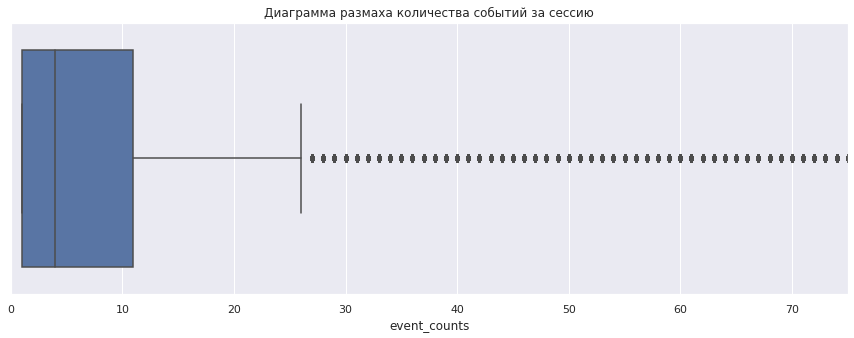

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Диаграмма размаха количества событий за сессию')
plt.xlim(0, 75)
sns.boxplot(x=event_counts);

### `event_action` - тип события    

Пустых значений в колонке нет. Уникальных значений - 230.  
Только 8 из них являются целевыми в задаче. И их число составляет 104 908 (0.66% от всех событий).  

Самыми популярными событиями являются: `view_card`, `view_new_card`, `sub_landing`.  
Самыми популярными целевыми событиями являются: `sub_car_claim_click`, `sub_open_dialog_click`.

In [ ]:
missings = count_missings(hits['event_action'])
print(f'Количество пустых значений в `event_action`: {missings}')

Количество пустых значений в `event_action`: 0


In [ ]:
print(f'Количество уникальных значений в `event_action`: '
      f'{hits["event_action"].nunique()}')

Количество уникальных значений в `event_action`: 230


In [ ]:
hits['event_action'].value_counts().head(25)

view_card                             3558985
view_new_card                         3551009
sub_landing                           1798117
go_to_car_card                         973666
sub_view_cars_click                    791515
search_form_region                     512069
search_form_search_btn                 433748
sap_search_form_cost_to                356596
showed_number_ads                      326274
pagination_click                       248944
search_form_mark_select                222652
quiz_show                              214037
search_form_model_select               211890
sap_search_form_cost_from              188129
photos_all                             181493
search_form_search_car_type_select     174877
photos                                 158543
sub_car_page                           130310
view_more_click                        109971
search_kpp                              79465
sub_header_link_click                   79192
proactive invitation shown        

In [ ]:
print(f'Количество целевых событий в hits:\n')
target_counts = hits['event_action'].value_counts()[target_events]

all = target_counts.sum()
print(f'Всего ({as_percent(all/len(hits))}) {all:>23}')
target_counts.sort_values(ascending=False)

Количество целевых событий в hits:

Всего (0.66%)                  104289


sub_car_claim_click             37928
sub_open_dialog_click           25870
sub_submit_success              18439
sub_car_claim_submit_click      12359
sub_call_number_click            3653
sub_callback_submit_click        3074
sub_car_request_submit_click     2966
Name: event_action, dtype: int64

### Выделение целевой переменной  

Целевую переменную считаем положительной, если за сессию состоялось хотя бы одно из целевых событий. Для тех сессий в `sessions`, для которых не нашлось ни одного события в `hits`, целевую переменную заполняем значением `False`. 

Целевая переменная распределена неравномерно - только 2.7% сессий закончилось совершением целевого действия.

In [ ]:
hits['target'] = hits['event_action'].isin(target_events)
target = hits.groupby('session_id')['target'].any()
sessions = sessions.join(target, on='session_id')

In [ ]:
print('Распределение целевой переменной:')
sessions['target'].value_counts(dropna=False, normalize=True).apply(as_percent)

Распределение целевой переменной:


False    90.43%
NaN       6.87%
True      2.70%
Name: target, dtype: object

In [ ]:
sessions['target'] = sessions['target'].fillna(False).astype(int)

## Анализ `sessions`

### Общая информация  

В таблице 1 860 042 строки и 18 колонок. Дубликатов нет.  
Одна колонка имеет численный тип (`visit_number`), одна колонка может быть разбита на две численных (`device_screen_resolution`), две колонки представляют дату (`visit_date`) и время (`visit_time`), а остальные колонки категориальные.  



In [ ]:
sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [ ]:
sessions.drop(columns='target').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [ ]:
print(f'Количество дубликатов в sessions: {sessions.duplicated().sum()}')

Количество дубликатов в sessions: 0


### `session_id` - ID визита  

Пустых значений в колонке нет. Все значения в колонке уникальны.  
Данная колонка будет использоваться в качестве индекса в окончательном датасете.

In [ ]:
missings = count_missings(sessions['session_id'])
print(f'Количество пустых значений в `session_id`: {missings}')

Количество пустых значений в `session_id`: 0


In [ ]:
all_unique = sessions['session_id'].nunique() == len(sessions)
print(f'Все значения колонки `session_id` уникальны: {all_unique}')

Все значения колонки `session_id` уникальны: True


### `client_id` - ID посетителя  

Пустых значений в колонке нет. А уникальных значений слишком много.

Вряд ли получится вытащить полезную информацию из этой колонки. Она просто не будет использоваться.  


In [ ]:
missings = count_missings(sessions["client_id"])
print(f'Количество пустых значений в `client_id`: {missings}')

Количество пустых значений в `client_id`: 0


In [ ]:
print(f'Количество уникальных значений в `client_id`: '
      f'{sessions["client_id"].nunique()}')

Количество уникальных значений в `client_id`: 1391717


### `visit_date` - дата визита  

Пустых значений в колонке нет.  

Диапазон представленных дат: с 19 мая 2021 по 31 декабря 2021.  
Можно предположить, что даны полные данные за 2021 год, так как сервис "СберАвтоподписка" начал работу как раз в мае 2021.  

В целом на графике количества посещений наблюдается легкий восходящий тренд.  
И ещё на графике очень заметен пик посещений в мае 2021, скорее всего это связано с рекламной кампанией, новостями о новом сервисе, хайпом.  
Больше сессий происходит и больше целевых действий совершается в начале недели.

Сама колонка `visit_date` участвовать в окончательном датасете не будет, но из неё можно получить признаки `visit_date_weekday` - день недели, `visit_date_weekend` - выходной ли, `visit_date_day` - день месяца, `visit_date_holiday` - является ли день праздничным в России.

In [ ]:
sessions['visit_date'] = pd.to_datetime(sessions['visit_date'])

In [ ]:
missings = count_missings(sessions['visit_date'])
print(f'Количество пустых значений в `visit_date`: {missings}')

Количество пустых значений в `visit_date`: 0


In [ ]:
n_unique = sessions['visit_date'].nunique()
print(f'Количество уникальных значений в `visit_date`: {n_unique}')

Количество уникальных значений в `visit_date`: 226


In [ ]:
sessions['visit_date'].describe(datetime_is_numeric=True)

count                          1860042
mean     2021-09-26 11:45:55.389394176
min                2021-05-19 00:00:00
25%                2021-08-02 00:00:00
50%                2021-10-06 00:00:00
75%                2021-11-23 00:00:00
max                2021-12-31 00:00:00
Name: visit_date, dtype: object

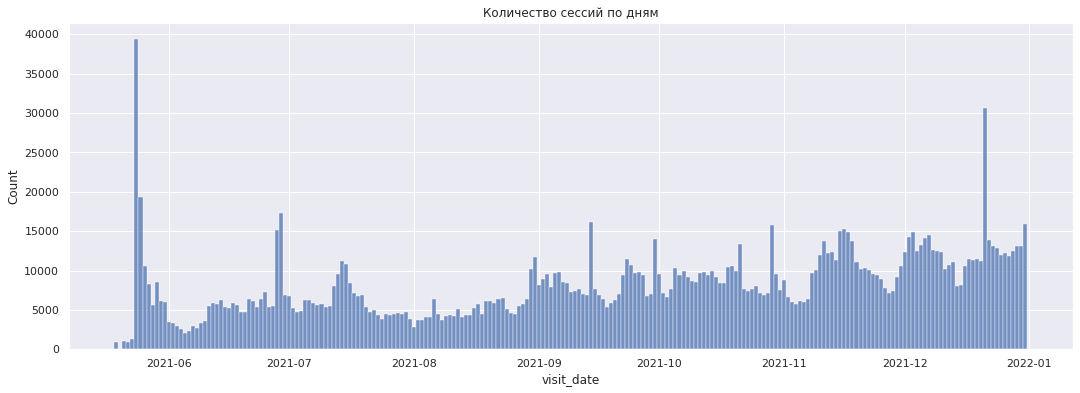

In [ ]:
sns.histplot(sessions, x='visit_date', discrete=True)
plt.title('Количество сессий по дням');

Получим новый признак - день недели `visit_date_weekday`.

In [ ]:
sessions['visit_date_weekday'] = sessions['visit_date'].dt.day_of_week

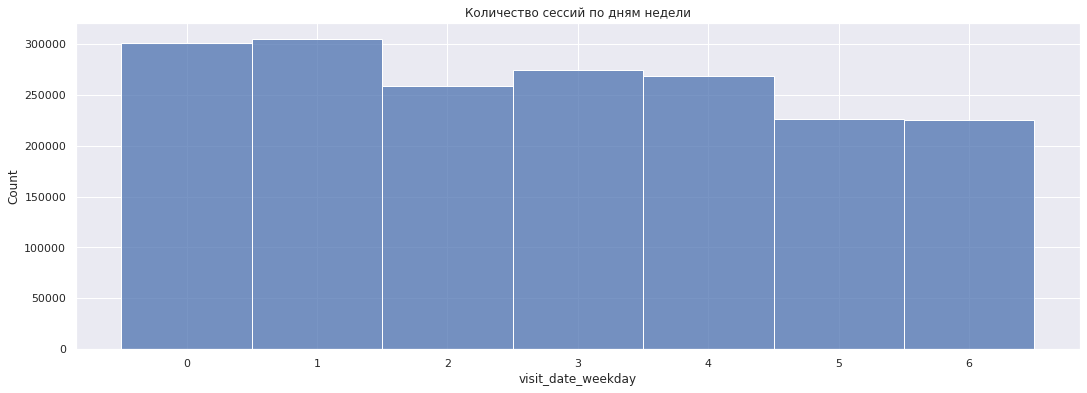

In [ ]:
sns.histplot(data=sessions, x='visit_date_weekday', discrete=True)
plt.title('Количество сессий по дням недели');

In [ ]:
print('Процент целевых действий по дням недели:')
target_percentage(sessions, 'visit_date_weekday', index_name='День недели')

Процент целевых действий по дням недели:


,Количество объектов,Доля от общего числа,Процент целевых действий
День недели,,,
0,300906,16.18%,3.15%
1,305130,16.40%,2.84%
2,258616,13.90%,2.81%
3,274462,14.76%,2.63%
5,226397,12.17%,2.46%
6,225712,12.13%,2.45%
4,268819,14.45%,2.44%


Получим новый признак, говорящий о выходном дне `visit_date_weekend`.

In [ ]:
sessions['visit_date_weekend'] = sessions['visit_date_weekday'] > 4

In [ ]:
print('Распределение выходных дней:')
target_percentage(sessions, 'visit_date_weekend', index_name='Выходной')

Распределение выходных дней:


,Количество объектов,Доля от общего числа,Процент целевых действий
Выходной,,,
False,1407933,75.69%,2.78%
True,452109,24.31%,2.46%


Получим новый признак - день месяца `visit_date_day`.

In [ ]:
sessions['visit_date_day'] = sessions['visit_date'].dt.day

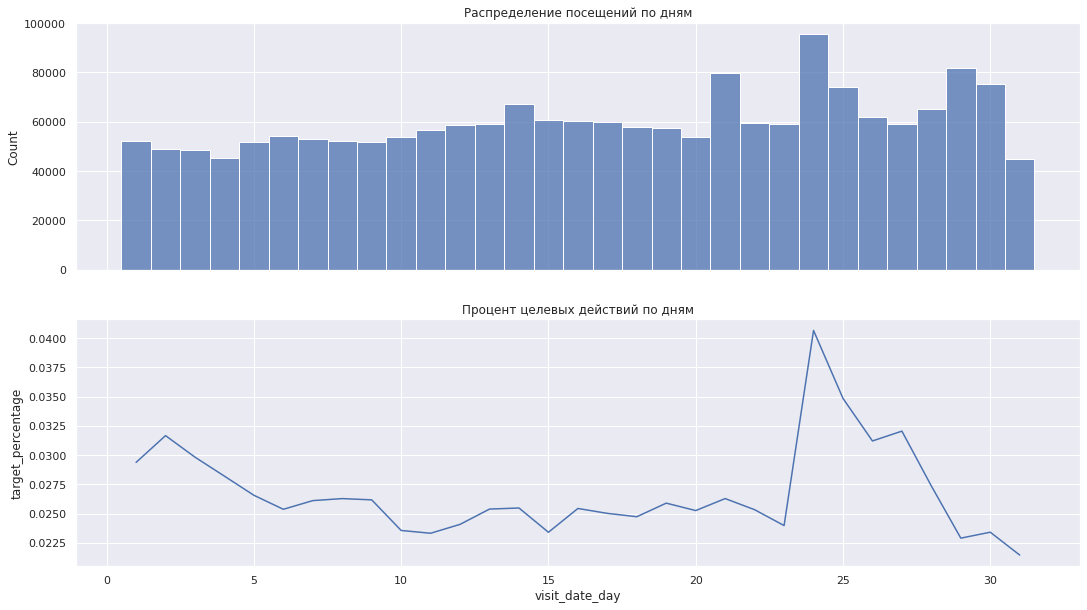

In [ ]:
_, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(18, 10))

ax1.set_title('Распределение посещений по дням')
sns.histplot(data=sessions, x='visit_date_day', discrete=True, ax=ax1)

target_by_day = target_percentage(sessions, 'visit_date_day', 
                                  percent=False, only_target=True)
ax2.set_title('Процент целевых действий по дням')
sns.lineplot(data=target_by_day, ax=ax2);

Получим новый признак, который говорит о наличии праздника в этот день `visit_date_holiday`.

In [ ]:
sessions['visit_date_holiday'] = sessions['visit_date'].isin(russian_holidays)

In [ ]:
print('Распределение праздничных дней:')
target_percentage(sessions, 'visit_date_holiday', index_name='Праздник')

Распределение праздничных дней:


,Количество объектов,Доля от общего числа,Процент целевых действий
Праздник,,,
False,1820148,97.86%,2.71%
True,39894,2.14%,2.54%


### `visit_time` - время визита  

Пустых значений в колонке нет. 

Временные значения представлены от 00:00:00 до 23:59:59, то есть покрывают весь день.  
Пик посещений сайта наблюдается в 14:00, то есть в середине дня.  
Упадок количества посещений - в середине ночи, в 04:00.  

Больший процент сессий закрывается целевым действием в середине дня (11:00-16:00), а меньший - ночью (2:00-6:00).  
Большинство сессий происходит на нулевой минуте каждого часа, причём с большим процентом целевых действий. Это больше похоже на алгоритмические действия, чем на реальные посещения сайта пользователем.

Сам по себе признак `visit_time` неудобен в использовании, но из него можно получить полезные признаки, например, `visit_hour` - час визита пользователя, `visit_minute` - минута визита, `visit_time_night` - была ли ночь во время визита пользователя.

In [ ]:
sessions['visit_time'] = pd.to_datetime(sessions['visit_time'])

In [ ]:
missings = count_missings(sessions['visit_time'])
print(f'Количество пустых значений в `visit_time`: {missings}')

Количество пустых значений в `visit_time`: 0


In [ ]:
sessions['visit_time'].describe(datetime_is_numeric=True)

count                          1860042
mean     2022-11-14 13:49:53.502090752
min                2022-11-14 00:00:00
25%                2022-11-14 10:00:00
50%                2022-11-14 14:09:06
75%                2022-11-14 19:00:00
max                2022-11-14 23:59:59
Name: visit_time, dtype: object

Получим новый признак - количество часов `visit_time_hour`.

In [ ]:
sessions['visit_time_hour'] = sessions['visit_time'].dt.hour

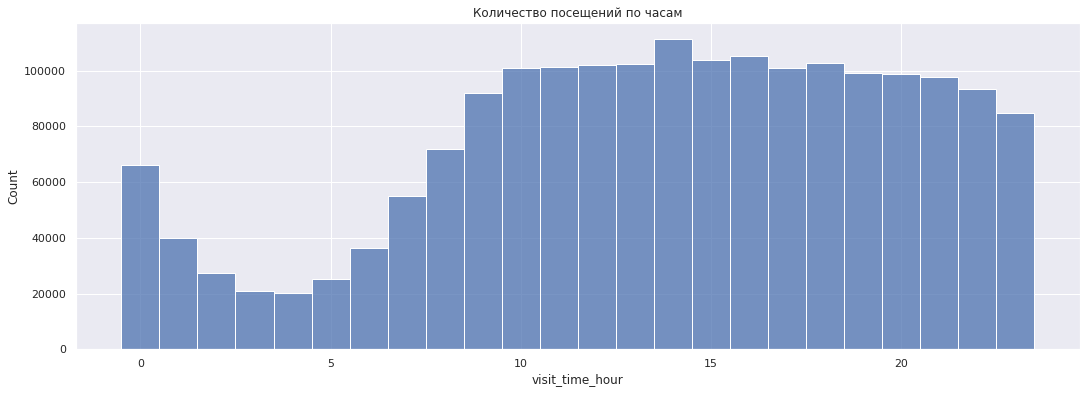

In [ ]:
sns.histplot(data=sessions, x='visit_time_hour', discrete=True)
plt.title('Количество посещений по часам');

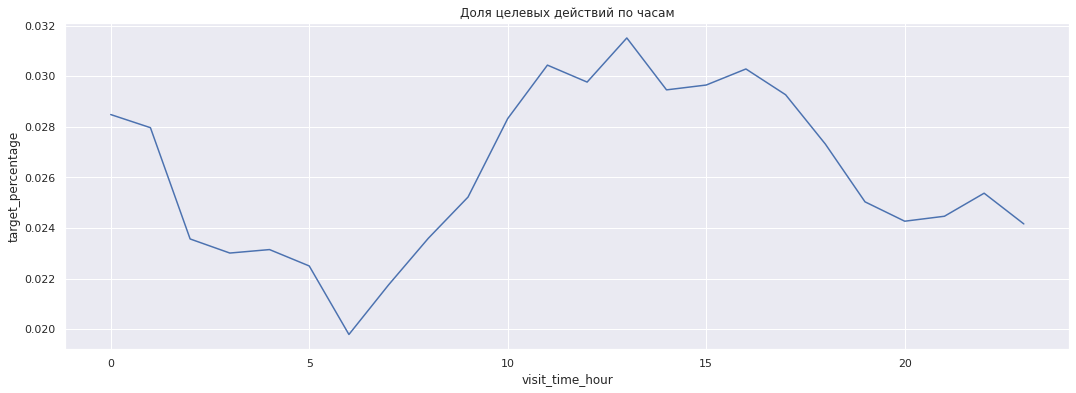

In [ ]:
target_by_hour = target_percentage(sessions, 'visit_time_hour', 
                                   percent=False, only_target=True)
sns.lineplot(data=target_by_hour)
plt.title('Доля целевых действий по часам');

Получим новый признак - количество минут `visit_time_minute`.

In [ ]:
sessions['visit_time_minute'] = sessions['visit_time'].dt.minute

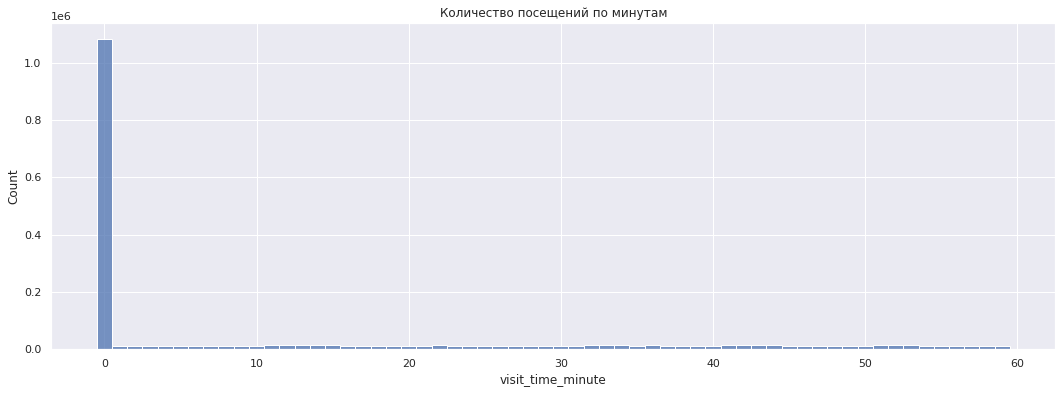

In [ ]:
sns.histplot(data=sessions, x='visit_time_minute', discrete=True)
plt.title('Количество посещений по минутам');

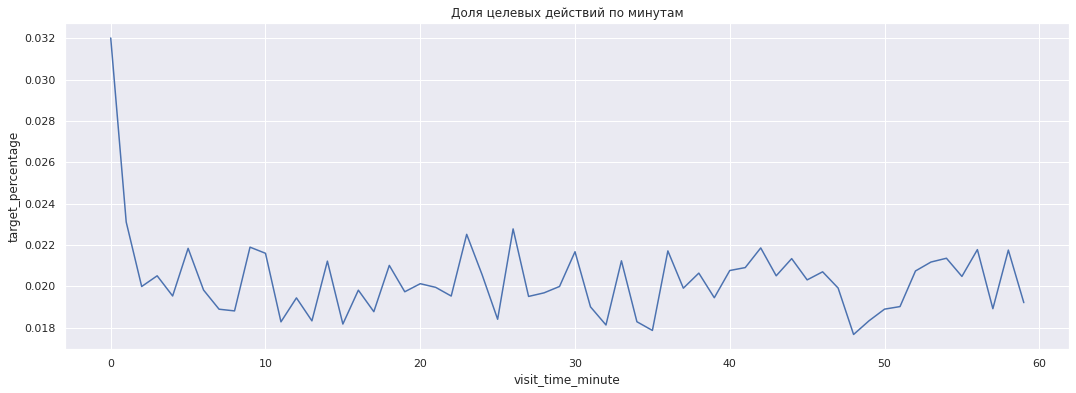

In [ ]:
target_by_minute = target_percentage(sessions, 'visit_time_minute', 
                                     percent=False, only_target=True)
sns.lineplot(data=target_by_minute)
plt.title('Доля целевых действий по минутам');

In [ ]:
sessions['visit_time_minute_is_zero'] = sessions['visit_time_minute'] == 0
target_percentage(sessions, 'visit_time_minute_is_zero', index_name='0 минут')

,Количество объектов,Доля от общего числа,Процент целевых действий
0 минут,,,
True,1083333,58.24%,3.20%
False,776709,41.76%,2.01%


Создадим новый признак, говорящий о наступлении ночи - `visit_time_night`.

In [ ]:
sessions['visit_time_night'] = sessions['visit_time_hour'] < 9

In [ ]:
print('Распределение целевых действий ночью и днём:')
target_percentage(sessions, 'visit_time_night', index_name='Ночное время')

Распределение целевых действий ночью и днём:


,Количество объектов,Доля от общего числа,Процент целевых действий
Ночное время,,,
False,1496535,80.46%,2.77%
True,363507,19.54%,2.42%


### `visit_number` - порядковый номер визита посетителя  

В колонке нет пустых значений.  

Номер колеблется от 1 до 564 (явно есть выбросы) посещений сайта. Хотя большинство пользователей ограничиваются одним-двумя посещениями.  

Похоже, что чем чаще пользователь заходит на сайт, тем выше вероятность, что он совершит целевое действие.  
Вероятно, первый раз пользователи заходят на сайт, чтобы познакомиться с предложением, а если их оно заинтересует, то они вернутся ещё раз.

In [ ]:
missings = count_missings(sessions['visit_number'])
print(f'Количество пустых значений в `visit_number`: {missings}')

Количество пустых значений в `visit_number`: 0


In [ ]:
sessions['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

count    1860042.0
mean           2.7
std           11.8
min            1.0
25%            1.0
50%            1.0
75%            2.0
max          564.0
Name: visit_number, dtype: object

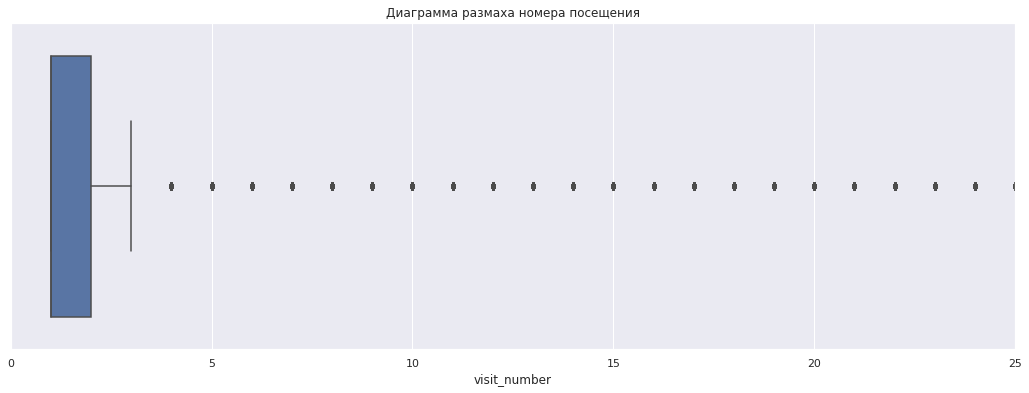

In [ ]:
sns.boxplot(data=sessions, x='visit_number')
plt.xlim(0, 25)
plt.title('Диаграмма размаха номера посещения');

In [ ]:
# приведём все выбросы к значению 4
sessions['visit_number_no_outliers'] = \
    sessions['visit_number'].apply(lambda x: x if x < 4 else 4)

In [ ]:
print('Процент успешных сессий в зависимости от номера посещения: ')
target_percentage(sessions, 'visit_number_no_outliers', 
                  index_name='Номер посещения')

Процент успешных сессий в зависимости от номера посещения: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Номер посещения,,,
4,166969,8.98%,4.37%
3,81068,4.36%,3.76%
2,235656,12.67%,3.23%
1,1376349,74.00%,2.35%


### `utm_source` - канал привлечения  

Пропусков в колонке не много - 97.  

Уникальных значений много (293) и вряд ли они несут много полезной информации, можно в окончательный датасет взять только самые частые значения.  

15% трафика из социальных сетей. Но процент целевых действий для него в два раза ниже, чем для остального трафика.  
Для популярных каналов привлечения процент целевых действий меняется от 1.21% до 5.43%.

In [ ]:
missings = count_missings(sessions['utm_source'])
print(f'Количество пустых значений в `utm_source`: {missings}')

Количество пустых значений в `utm_source`: 97


In [ ]:
n_unique = sessions['utm_source'].nunique()
print(f'Количество уникальных значений в `utm_source`: {n_unique}')

Количество уникальных значений в `utm_source`: 293


In [ ]:
sessions['utm_source'].value_counts(dropna=False).head(15)

ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
Name: utm_source, dtype: int64

In [ ]:
print('Процент целевых действий для частых значений канала привлечения:')
sessions['utm_source_frequent'] = replace_rare(sessions['utm_source'])
target_percentage(sessions, 'utm_source_frequent', 
                  index_name='Канал привлечения')

Процент целевых действий для частых значений канала привлечения:


,Количество объектов,Доля от общего числа,Процент целевых действий
Канал привлечения,,,
bByPQxmDaMXgpHeypKSM,102287,5.50%,5.43%
fDLlAcSmythWSCVMvqvL,300575,16.16%,3.50%
BHcvLfOaCWvWTykYqHVe,116320,6.25%,3.34%
ZpYIoDJMcFzVoPFsHGJL,578290,31.09%,2.77%
kjsLglQLzykiRbcDiGcD,266354,14.32%,2.36%
rare_other,310017,16.67%,1.87%
MvfHsxITijuriZxsqZqt,186199,10.01%,1.21%


Создадим новый признак, говорящий о том, что пользователь перешёл на сайт из социальных сетей - `utm_source_is_social`.

In [ ]:
sessions['utm_source_is_social'] = \
    sessions['utm_source'].isin(social_media_sources)

In [ ]:
print('Процент целевых действий для пользователей из соцсетей и остальных:')
target_percentage(sessions, 'utm_source_is_social', index_name='Из соцсетей')

Процент целевых действий для пользователей из соцсетей и остальных:


,Количество объектов,Доля от общего числа,Процент целевых действий
Из соцсетей,,,
False,1585815,85.26%,2.92%
True,274227,14.74%,1.47%


### `utm_medium` - тип привлечения  

Пустых значений в колонке `utm_medium` 301 055 - значения (none) и  (not set). Уникальных значений немного - 56.  

Множество значений появляется в датасете слишком малое количество раз. 

Органический трафик составляет 28%. И для него процент целевых действий значительно выше, чем для остальных типов привлечения.  
Самые популярные типы трафика: banner, cpc, cpm, refferal, organic.  

Для самых частых значений `utm_medium` процент целевых действий меняется от 1.04% до 5.38%.

In [ ]:
missings = count_missings(sessions['utm_medium'])
print(f'Количество пустых значений в `utm_medium`: {missings}')

Количество пустых значений в `utm_medium`: 301055


In [ ]:
n_unique = sessions['utm_medium'].nunique()
print(f'Количество уникальных значений в `utm_medium`: {n_unique}')

Количество уникальных значений в `utm_medium`: 56


In [ ]:
sessions['utm_medium'].value_counts(dropna=False).head(15)

banner             552272
cpc                434794
(none)             300575
cpm                242083
referral           152050
organic             63034
email               29240
push                28035
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
Name: utm_medium, dtype: int64

In [ ]:
print('Процент целевых действий для частых значений типа привлечения:')
sessions['utm_medium_frequent'] = replace_rare(sessions['utm_medium'])
target_percentage(sessions, 'utm_medium_frequent', index_name='Тип привлечения')

Процент целевых действий для частых значений типа привлечения:


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип привлечения,,,
referral,152050,8.17%,5.38%
(none),300575,16.16%,3.50%
banner,552272,29.69%,2.74%
rare_other,178268,9.58%,2.49%
cpc,434794,23.38%,2.19%
cpm,242083,13.01%,1.04%


Построим новый признак, отвечающий за органический трафик - `utm_medium_is_organic`.

In [ ]:
sessions['utm_medium_is_organic'] = sessions['utm_medium'].isin(organic_mediums)

In [ ]:
print('Распределение органического трафика:')
target_percentage(sessions, 'utm_medium_is_organic', 
                  index_name='Органический трафик')

Распределение органического трафика:


,Количество объектов,Доля от общего числа,Процент целевых действий
Органический трафик,,,
True,515659,27.72%,4.04%
False,1344383,72.28%,2.19%


### `utm_campaign` - рекламная кампания  

12% значений в колонке пропущено.  
Уникальных значений в колонке 412, причём большая часть уникальных значений встречается в датасете очень редко. 

Для самых частых значений процент целевых действий меняется от 0.99% до 4.10%.

In [ ]:
missings = count_missings(sessions['utm_campaign']) / len(sessions)
print(f'Количество пропущенных значений в `utm_campaign`: {missings:0.2%}')

Количество пропущенных значений в `utm_campaign`: 11.81%


In [ ]:
n_unique = sessions['utm_campaign'].nunique()
print(f'Количество уникальных значений в `utm_campaign` = {n_unique}')

Количество уникальных значений в `utm_campaign` = 412


In [ ]:
sessions['utm_campaign'].value_counts(dropna=False).head(15)

LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15706
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12370
bJJuEXRheRIxXEaYIXqM     12232
Name: utm_campaign, dtype: int64

In [ ]:
print('Процент целевых действий для самых частых значений рекламной кампании:')
sessions['utm_campaign_frequent'] = replace_rare(sessions['utm_campaign'], 0.05)
target_percentage(sessions, 'utm_campaign_frequent', 
                  index_name='Рекламная кампания')

Процент целевых действий для самых частых значений рекламной кампании:


,Количество объектов,Доля от общего числа,Процент целевых действий
Рекламная кампания,,,
LTuZkdKfxRGVceoWkVyg,463481,24.92%,4.10%
gecBYcKZCPMcVYdSSzKP,134042,7.21%,3.39%
(nan),219603,11.81%,3.27%
LEoPHuyFvzoNfnzGgfcd,324044,17.42%,2.88%
rare_other,471512,25.35%,1.65%
FTjNLDyTrXaWYgZymFkV,247360,13.30%,0.99%


### `utm_adcontent`  

18% значений в колонке пропущено.  
В колонке 286 уникальных значений, но большая их часть слишком редко встречается в данных.  

Для популярных значений процент целевых действий меняется от 1.08% до 3.37%.

In [ ]:
missings = count_missings(sessions['utm_adcontent']) / len(sessions)
print(f'Количество пропущенных значений в `utm_adcontent`: {missings:0.2%}')

Количество пропущенных значений в `utm_adcontent`: 18.04%


In [ ]:
n_unique = sessions['utm_adcontent'].nunique()
print(f'Количество уникальных значений в `utm_adcontent` = {n_unique}')

Количество уникальных значений в `utm_adcontent` = 286


In [ ]:
sessions['utm_adcontent'].value_counts(dropna=False).head(15)

JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7319
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
Name: utm_adcontent, dtype: int64

In [ ]:
print('Процент целевых действий для частых значений utm_adcontent:')
sessions['utm_adcontent_frequent'] = replace_rare(sessions['utm_adcontent'])
target_percentage(sessions, 'utm_adcontent_frequent')

Процент целевых действий для частых значений utm_adcontent:


,Количество объектов,Доля от общего числа,Процент целевых действий
utm_adcontent_frequent,,,
JNHcPlZPxEMWDnRiyoBf,1006599,54.12%,3.37%
(nan),335615,18.04%,2.61%
vCIpmpaGBnIQhyYNkXqp,181048,9.73%,2.16%
xhoenQgDQsgfEPYNPwKO,113072,6.08%,1.12%
rare_other,223708,12.03%,1.08%


### `utm_keyword` - ключевое слово  

Пропущенных значений в колонке очень много - 58%. И уникальных значений в колонке - 1219, что говорит о малой ценности этой колонки. Скорее всего из этой колонки будет взято только самое популярное значение puhZPIYqKXeFPaUviSjo.  

Больший процент целевых действий у объектов с пропущенными значениями keyword.

In [ ]:
missings = count_missings(sessions['utm_keyword']) / len(sessions)
print(f'Количество пропущенных значений в `utm_keyword`: {missings:0.2%}')

Количество пропущенных значений в `utm_keyword`: 58.17%


In [ ]:
n_unique = sessions['utm_keyword'].nunique()
print(f'Количество уникальных значений в `utm_keyword` = {n_unique}')

Количество уникальных значений в `utm_keyword` = 1219


In [ ]:
sessions['utm_keyword'].value_counts(dropna=False).head(15)

NaN                     1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
hAmNSZmQkKQKAjZEGlgb      11297
UKNBOHebRIIsQRsjNKay      10946
IGUCNvHlhfHpROGclCit       7568
RkpOyeEPgcMBSDuHLQcj       6978
JajANoFxoqXfKRNBUhzx       6758
BmOOOIoWGHEfxEfoUezs       6602
ZNhSIPchlbnKwZWcsKzz       5661
pucKZkLDtpMDBTobJAJG       5391
RrhnkuoaqckNtJpAZDzH       5004
YQXPpoLsxnykCWKhGEmI       4874
Name: utm_keyword, dtype: int64

In [ ]:
print('Процент целевых действий для частых значений utm_keyword:')
sessions['utm_keyword_frequent'] = replace_rare(sessions['utm_keyword'], 0.01)
target_percentage(sessions, 'utm_keyword_frequent')

Процент целевых действий для частых значений utm_keyword:


,Количество объектов,Доля от общего числа,Процент целевых действий
utm_keyword_frequent,,,
(nan),1082061,58.17%,3.20%
puhZPIYqKXeFPaUviSjo,506819,27.25%,2.21%
rare_other,246921,13.28%,1.81%
aXQzDWsJuGXeBXexNHjc,24241,1.30%,0.30%


### `device_category` - тип устройства  

Пропущенных значений в колонке нет.  
Уникальных значений немного, а значит проблем с использованием колонки не возникнет.  

С компьютера пользователи совершили больше (в процентах) целевых действий, чем с мобильных устройств.  


In [ ]:
missings = count_missings(sessions['device_category'])
print(f'Количество пропущенных значений в `device_category`: {missings}')

Количество пропущенных значений в `device_category`: 0


In [ ]:
n_unique = sessions['device_category'].nunique()
print(f'Количество уникальных значений в `device_category` = {n_unique}')

Количество уникальных значений в `device_category` = 3


In [ ]:
sessions['device_category'].value_counts(dropna=False)

mobile     1474871
desktop     366863
tablet       18308
Name: device_category, dtype: int64

In [ ]:
print('Процент целевых действий по категориям устройств: ')
target_percentage(sessions, 'device_category', index_name='Тип устройства')

Процент целевых действий по категориям устройств: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип устройства,,,
desktop,366863,19.72%,3.14%
mobile,1474871,79.29%,2.60%
tablet,18308,0.98%,2.31%


### `device_os` - ОС устройства  

Пропущенных значений в колонке 58%. Уникальных значений - 13, но большинство встречается слишком редко.  

Больший процент целевых действий был совершен с устройств с неизвестной ОС и с Macintosh. 

In [ ]:
device_os = sessions['device_os']

In [ ]:
missings = count_missings(sessions['device_os']) / len(sessions)
print(f'Количество пропущенных значений в `device_os`: {missings:0.2%}')

Количество пропущенных значений в `device_os`: 57.55%


In [ ]:
n_unique = sessions['device_os'].nunique()
print(f'Количество уникальных значений в `device_os` = {n_unique}')

Количество уникальных значений в `device_os` = 13


In [ ]:
device_os.value_counts(dropna=False)

NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: device_os, dtype: int64

In [ ]:
print('Процент целевых действий для популярных ОС: ')
sessions['device_os_frequent'] = replace_rare(sessions['device_os'], 0.01)
target_percentage(sessions, 'device_os_frequent', index_name='ОС')

Процент целевых действий для популярных ОС: 


,Количество объектов,Доля от общего числа,Процент целевых действий
ОС,,,
(nan),1070138,57.53%,3.22%
Macintosh,24824,1.33%,3.11%
Android,464054,24.95%,2.04%
iOS,207104,11.13%,1.89%
Windows,88307,4.75%,1.85%
rare_other,5615,0.30%,1.60%


### `device_brand` - марка устройства  

Количество пропущенных значений в колонке около 20%. Уникальных значений 205.  

Процент целевых действий для популярных марок меняется в небольшом промежутке от 2.29% до 3.14%. Причём больший процент с устройств неизвестной марки.

In [ ]:
missings = count_missings(sessions['device_brand']) / len(sessions)
print(f'Количество пропущенных значений в `device_brand`: {missings:0.2%}')

Количество пропущенных значений в `device_brand`: 20.68%


In [ ]:
n_unique = sessions['device_brand'].nunique()
print(f'Количество уникальных значений в `device_brand` = {n_unique}')

Количество уникальных значений в `device_brand` = 205


In [ ]:
sessions['device_brand'].value_counts(dropna=False).head(15)

Apple        551088
NaN          367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Name: device_brand, dtype: int64

In [ ]:
print('Процент целевых действий для частых значений марки устройства:')
sessions['device_brand_frequent'] = replace_rare(sessions['device_brand'])
target_percentage(sessions, 'device_brand_frequent', 
                  index_name='Марка устройства')

Процент целевых действий для частых значений марки устройства:


,Количество объектов,Доля от общего числа,Процент целевых действий
Марка устройства,,,
(nan),367178,19.74%,3.14%
Samsung,332194,17.86%,3.03%
Apple,551088,29.63%,2.63%
Huawei,185853,9.99%,2.43%
rare_other,135362,7.28%,2.34%
Xiaomi,288367,15.50%,2.29%


### `device_model` - модель устройства  

Пропущенных значений в колонке - 99%, а значит использоваться она не будет.  


In [ ]:
missings = count_missings(sessions['device_model']) / len(sessions)
print(f'Количество пропущенных значений в `device_model`: {missings:0.2%}')

Количество пропущенных значений в `device_model`: 99.12%


In [ ]:
n_unique = sessions['device_model'].nunique()
print(f'Количество уникальных значений в `device_model` = {n_unique}')

Количество уникальных значений в `device_model` = 104


In [ ]:
sessions['device_model'].value_counts(dropna=False).head(15)

NaN                     1843704
AuMdmADEIoPXiWpTsBEj       9778
tWBQlsvNfHxRUjaPAfhd        653
cwMJxNXiWUgMUxGiCTPs        651
pTgAEPipQxDXCjPrJbHo        461
FJApgTrMAGHoxCxQVKws        372
tfPZFRbtlzEssBEesRwM        335
pcvPxfVFaAmhwFmvIeYd        325
aCLaTVQlHcXbUnQYQvIg        236
mzJXHtJPIOSHoHtgezIA        235
JAIKWwxRffFOXQcfGTVi        198
zFCiMWkbbAhTflrlLWnz        176
jXFxTkHxuiBKWOvUtsIa        170
mSVMBvlHFgftJaQAZEdp        152
AshpvdJdReafUzEMmWGr        141
Name: device_model, dtype: int64

In [ ]:
print('Распределение пропущенного и остальных значений device_model:')
sessions['device_model_frequent'] = replace_rare(sessions['device_model'], 0.01)
target_percentage(sessions, 'device_model_frequent')

Распределение пропущенного и остальных значений device_model:


,Количество объектов,Доля от общего числа,Процент целевых действий
device_model_frequent,,,
(nan),1843704,99.12%,2.71%
rare_other,16338,0.88%,2.09%


### `device_screen_resolution` - разрешение экрана  

Пропущенных значений в колонке всего 19 (значения '0x0', '(not set)'). Их было бы удобно заменить на самое частое значение в колонке. Уникальных значений очень много - 5039.  

Напрямую использовать признак не получится, но можно из него получить новые признаки, такие как: соотношение сторон, площадь, ширина и высота экрана.  

Но в таких производных признаках много выбросов, которые нужно будет обработать.  

Целевая переменная не коррелирует ни с одним производным признаком. Судя по диаграммам размаха те, пользователи, у которых разрешение экрана выше, более склонны совершить целевое действие.  

In [ ]:
missings = count_missings(sessions['device_screen_resolution'])
print(f'Пропущенных значений в `device_screen_resolution`:', missings)

Пропущенных значений в `device_screen_resolution`: 19


In [ ]:
missed_mask = sessions['device_screen_resolution'].isin(missing_values)
sessions[missed_mask]['device_screen_resolution'].value_counts(dropna=False)

0x0          11
(not set)     8
Name: device_screen_resolution, dtype: int64

In [ ]:
n_unique = sessions['device_screen_resolution'].nunique()
print(f'Уникальных значений в `device_screen_resolution` = {n_unique}')

Уникальных значений в `device_screen_resolution` = 5039


In [ ]:
sessions['device_screen_resolution'].value_counts(dropna=False).head()

414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
Name: device_screen_resolution, dtype: int64

Разобъём колонку на ширину и высоту - `device_screen_width` и `device_screen_height`.

In [ ]:
split = sessions['device_screen_resolution']\
    .replace(missing_values, '414x896')\
    .str.split('x', expand=True).astype(int)
sessions[['device_screen_width', 'device_screen_height']] = split

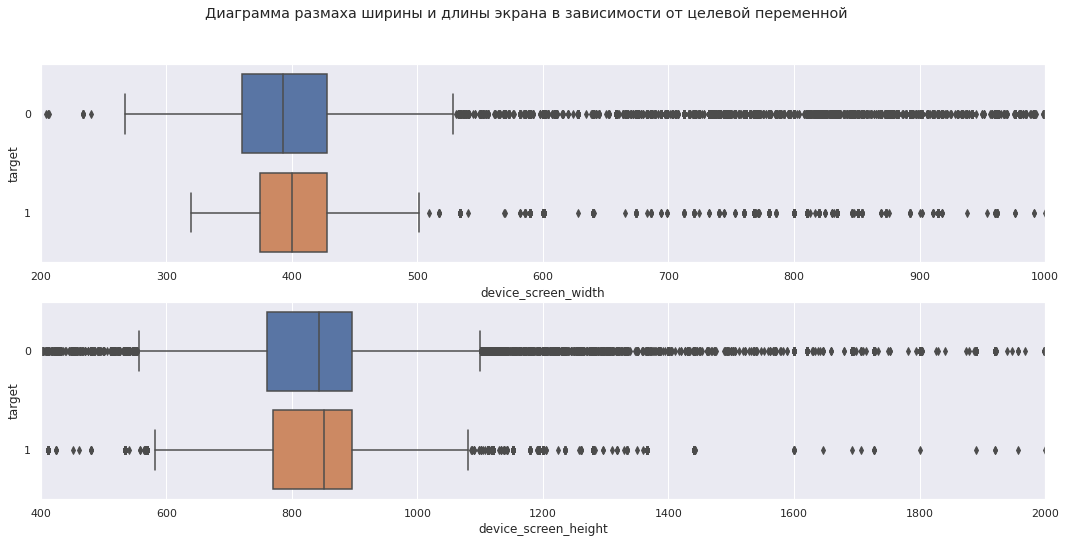

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

sns.boxplot(data=sessions, x='device_screen_width', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=sessions, x='device_screen_height', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(200, 1000)
ax2.set_xlim(400, 2000)

fig.suptitle(f'Диаграмма размаха ширины и длины экрана '
             f'в зависимости от целевой переменной')
plt.show()

Создадим дополнительные признаки - площадь экрана `device_screen_area` и соотношение сторон `device_screen_ratio`.

In [ ]:
sessions['device_screen_area'] = sessions['device_screen_width'] \
                                 * sessions['device_screen_height']
sessions['device_screen_ratio'] = sessions['device_screen_width'] \
                                 / sessions['device_screen_height']

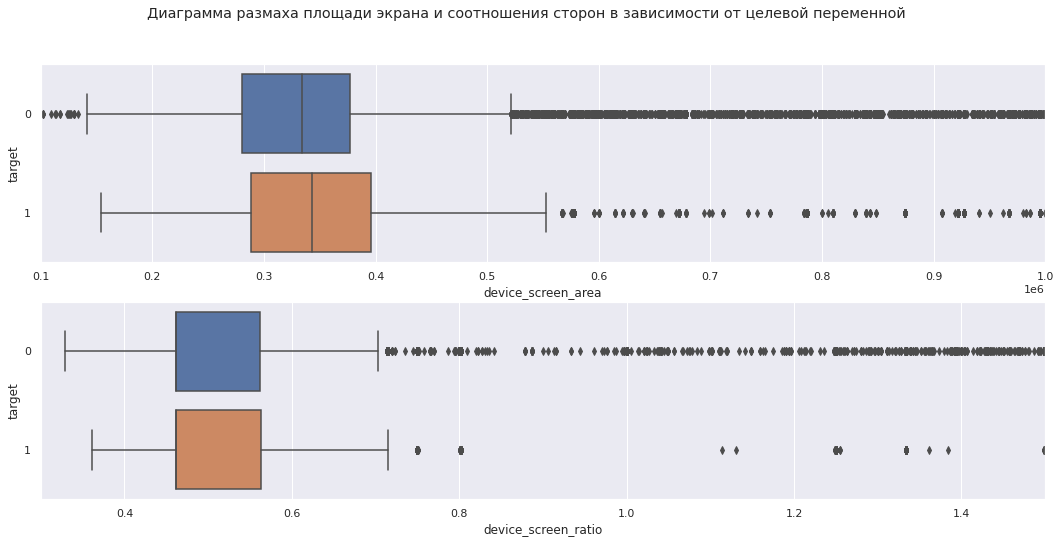

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

sns.boxplot(data=sessions, x='device_screen_area', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=sessions, x='device_screen_ratio', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(100_000, 1_000_000)
ax2.set_xlim(0.3, 1.5)

fig.suptitle(f'Диаграмма размаха площади экрана и соотношения сторон '
             f'в зависимости от целевой переменной')
plt.show()

### `device_browser` - браузер  

Пропущенных значений '(not set)' в колонке всего 17. Уникальных значений - 57, но большая часть встречается слишком редко.  

Больший процент целевых действий наблюдается с Яндекс Браузера.

In [ ]:
missings = count_missings(sessions['device_browser'])
print(f'Количество пропущенных значений в `device_browser`: {missings}')

Количество пропущенных значений в `device_browser`: 17


In [ ]:
n_unique = sessions['device_browser'].nunique()
print(f'Количество уникальных значений в `device_browser` = {n_unique}')

Количество уникальных значений в `device_browser` = 57


In [ ]:
sessions['device_browser'].value_counts(dropna=False).head(15)

Chrome                              1013436
Safari                               478562
YaBrowser                            133311
Safari (in-app)                       69912
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
Name: device_browser, dtype: int64

In [ ]:
print('Процент целевых действий для самых популярных браузеров:')
sessions['device_browser_frequent'] = replace_rare(sessions['device_browser'], 
                                                   tolerance=0.01)
target_percentage(sessions, 'device_browser_frequent', index_name='Браузер')

Процент целевых действий для самых популярных браузеров:


,Количество объектов,Доля от общего числа,Процент целевых действий
Браузер,,,
rare_other,35326,1.90%,3.18%
YaBrowser,133311,7.17%,3.07%
Android Webview,55369,2.98%,2.81%
Safari,478562,25.73%,2.78%
Chrome,1013436,54.48%,2.68%
Samsung Internet,47309,2.54%,2.66%
Opera,26817,1.44%,2.09%
Safari (in-app),69912,3.76%,1.75%


### `geo_country` - страна  

Пропущенных значений в колонке мало ('(not set)' - 1146). И большая часть пользователей из России, что неудивительно, так как сервис работает только здесь.  

И, естественно, пользователи из России совершают больше целевых действий.  


In [ ]:
missings = count_missings(sessions['geo_country'])
print(f'Количество пропущенных значений в `geo_country`: {missings}')

Количество пропущенных значений в `geo_country`: 1146


In [ ]:
n_unique = sessions['geo_country'].nunique()
print(f'Количество уникальных значений в `geo_country` = {n_unique}')

Количество уникальных значений в `geo_country` = 166


In [ ]:
sessions['geo_country'].value_counts(dropna=False).head(15)

Russia            1800565
United States       11784
Ukraine              9012
Ireland              4034
Belarus              3636
Sweden               2694
Kazakhstan           2279
Germany              2232
Turkey               1953
Netherlands          1549
Uzbekistan           1523
United Kingdom       1462
(not set)            1146
Kyrgyzstan            974
Georgia               935
Name: geo_country, dtype: int64

In [ ]:
print('Процент целевых действий для стран с наибольшим посещением сайта:')
sessions['geo_country_frequent'] = replace_rare(sessions['geo_country'], 0.002)
target_percentage(sessions, 'geo_country_frequent', index_name='Страна')

Процент целевых действий для стран с наибольшим посещением сайта:


,Количество объектов,Доля от общего числа,Процент целевых действий
Страна,,,
Russia,1800565,96.80%,2.73%
rare_other,34647,1.86%,2.58%
Ukraine,9012,0.48%,2.21%
United States,11784,0.63%,0.54%
Ireland,4034,0.22%,0.02%


Посмотрим на распределение целевой переменной в России и за рубежом - `geo_country_is_russia`.

In [ ]:
sessions['geo_country_is_russia'] = sessions['geo_country'] == 'Russia'

In [ ]:
print('Процент целевых действий в России:')
target_percentage(sessions, 'geo_country_is_russia', index_name='Россия')

Процент целевых действий в России:


,Количество объектов,Доля от общего числа,Процент целевых действий
Россия,,,
True,1800565,96.80%,2.73%
False,59477,3.20%,1.95%


### `geo_city` - город  

Пропущенных значений 4%.  
Уникальных значений - 2548, но действительно важные - только 'Moscow' и 'Saint Petersburg'. Можно выделить отдельно города московской области и самые крупные города по населению.  

43% сессий из Москвы, 5% из Московской области, а остальные из других городов. В Москве и области целевых действий больше, но не слишком значительно.  

Больший процент целевых действий в Москве и в пределах 100 км от Москвы. Это и неудивительно, так как именно здесь сервис и работает по большей части.

In [ ]:
missings = count_missings(sessions['geo_city']) /  len(sessions)
print(f'Количество пропущенных значений в `geo_city`: {missings:0.2%}')

Количество пропущенных значений в `geo_city`: 4.20%


In [ ]:
n_unique = sessions['geo_city'].nunique()
print(f'Количество уникальных значений в `geo_city` = {n_unique}')

Количество уникальных значений в `geo_city` = 2548


In [ ]:
sessions['geo_city'].value_counts(dropna=False).head(15)

Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Name: geo_city, dtype: int64

In [ ]:
print('Процент целевых действий для городов с наибольшим посещением сайта:')
sessions['geo_city_frequent'] = replace_rare(sessions['geo_city'], 0.01)
target_percentage(sessions, 'geo_city_frequent', index_name='Город')

Процент целевых действий для городов с наибольшим посещением сайта:


,Количество объектов,Доля от общего числа,Процент целевых действий
Город,,,
Kazan,29531,1.59%,3.86%
Krasnodar,32243,1.73%,3.35%
Ufa,21679,1.17%,2.95%
Moscow,805329,43.30%,2.93%
Samara,24992,1.34%,2.91%
rare_other,491725,26.44%,2.53%
Nizhny Novgorod,22227,1.19%,2.51%
Yekaterinburg,35788,1.92%,2.48%
Saint Petersburg,296788,15.96%,2.40%


Создадим новый признак, учитывающий города из Московской области - `geo_moscow_region`.

In [ ]:
sessions['geo_moscow_region'] = sessions['geo_city'].copy()
sessions['geo_moscow_region'][sessions['geo_city'] != 'Moscow'] = 'other'
region_mask = sessions['geo_city'].isin(moscow_region_cities)
sessions['geo_moscow_region'][region_mask] = 'Moscow region'

In [ ]:
print('Процент целевых действий в Московской области:')
target_percentage(sessions, 'geo_moscow_region', index_name='Москва или регион')

Процент целевых действий в Московской области:


,Количество объектов,Доля от общего числа,Процент целевых действий
Москва или регион,,,
Moscow,805329,43.30%,2.93%
Moscow region,101694,5.47%,2.87%
other,953019,51.24%,2.49%


Создадим новый признак для больших городов - `geo_city_is_big`.

In [ ]:
sessions['geo_city_is_big'] = sessions['geo_city'].isin(big_cities)

In [ ]:
print('Процент целевых действий для больших городов:')
target_percentage(sessions, 'geo_city_is_big', index_name='Большой город')

Процент целевых действий для больших городов:


,Количество объектов,Доля от общего числа,Процент целевых действий
Большой город,,,
True,1380287,74.21%,2.78%
False,479755,25.79%,2.49%


Построим признак - расстояние от Москвы `geo_city_distance_from_moscow`. Расстояния получены с помощью библиотеки `geopy` и сохранены для удобства в словарь в файле `additional_data.py`. Расстояния есть только для российских городов, для остальных расстояние -1.

In [ ]:
sessions['geo_city_distance_from_moscow'] = \
    sessions['geo_city'].apply(get_distance_from_moscow)

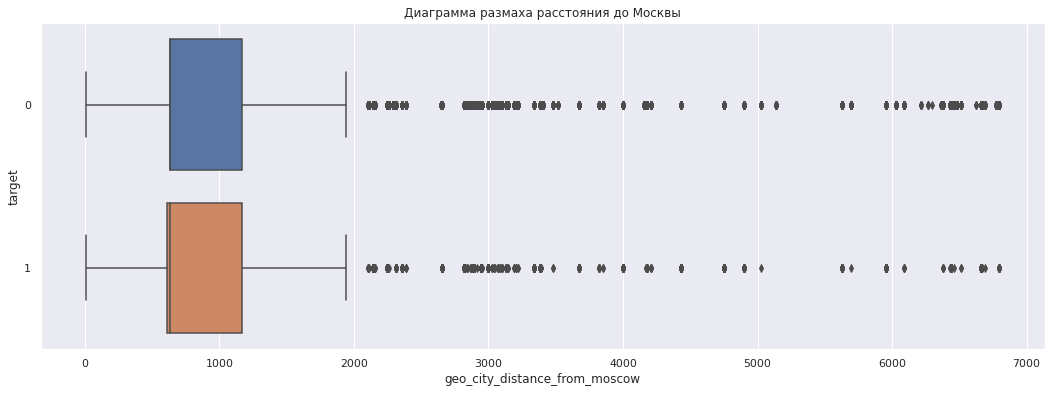

In [ ]:
positive_distances = sessions[sessions['geo_city_distance_from_moscow'] > 0]
sns.boxplot(data=positive_distances, x='geo_city_distance_from_moscow', 
            y='target', orient='h')
plt.title('Диаграмма размаха расстояния до Москвы');

Разобъём дистанцию на категории, чтобы оценить влияние расстояния на целевую переменную - `geo_city_distance_from_moscow_category`.

In [ ]:
def get_distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

sessions['geo_city_distance_from_moscow_category'] = \
    sessions['geo_city_distance_from_moscow'].apply(get_distance_category)

In [ ]:
print('Распределение объектов по расстоянию до Москвы:')
target_percentage(sessions, 'geo_city_distance_from_moscow_category', 
                  index_name='Дистанция до Москвы')

Распределение объектов по расстоянию до Москвы:


,Количество объектов,Доля от общего числа,Процент целевых действий
Дистанция до Москвы,,,
moscow,805329,43.30%,2.93%
< 100 km,102673,5.52%,2.90%
1000-3000 km,229616,12.34%,2.77%
500-1000 km,421113,22.64%,2.54%
100-500 km,107529,5.78%,2.50%
>= 3000 km,61687,3.32%,2.21%
no distance,132095,7.10%,1.96%


## Взаимодействия признаков

### Корреляции

Из численных признаков действительно коррелируют между собой только те, которые образованы из `device_screen_resolution`.  

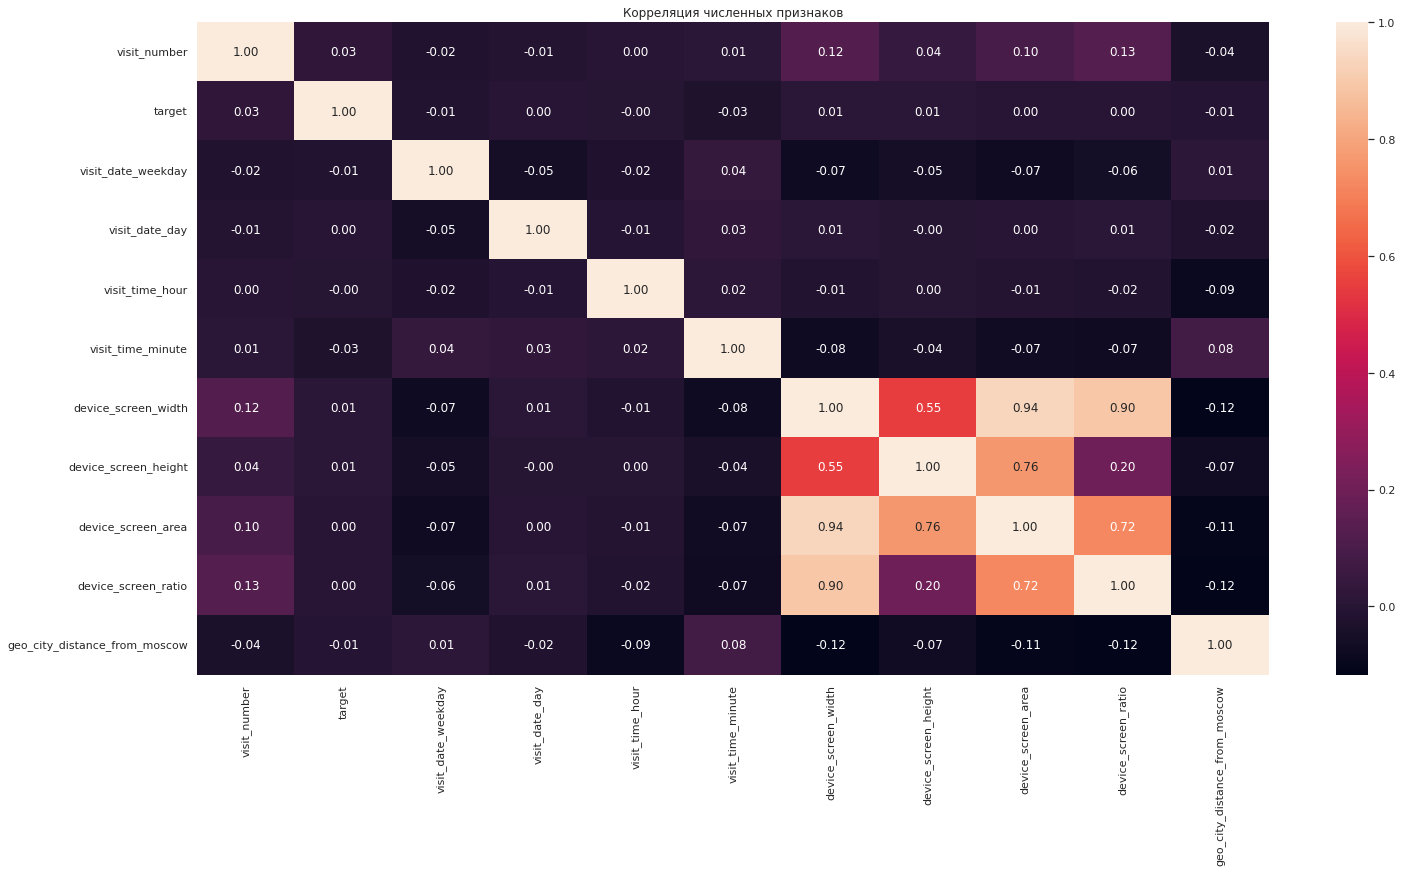

In [ ]:
numerical_columns = [
    'visit_number', 'target', 'visit_date_weekday', 'visit_date_day', 
    'visit_time_hour', 'visit_time_minute', 'device_screen_width', 
    'device_screen_height', 'device_screen_area', 'device_screen_ratio', 
    'geo_city_distance_from_moscow']

plt.figure(figsize=(24,12))
sns.heatmap(sessions[numerical_columns].corr(), annot=True, fmt='0.2f')
plt.title('Корреляция численных признаков');

### Категориальные признаки

Процент целевых действий органического трафика снижается гораздо быстрее к концу недели, чем процент неорганического трафика.

Органический трафик чаще совершает целевые действия с компьютера, а неорганический - со смартфона.

Для реферального типа привлечения больше всего действий в первую минуту часа, возможно из-за недобросовестной накрутки реферальных действий.

In [ ]:
def target_ratio(data: pd.Series) -> str:
    """Возвращает процент целевых действий."""
    return as_percent(data.sum() / data.count())

In [ ]:
print('Целевые действия органического трафика по дням недели:')
sessions.pivot_table(
    index='visit_date_weekday', columns='utm_medium_is_organic', 
    values='target', aggfunc=[target_ratio, 'count'])

Целевые действия органического трафика по дням недели:


target_ratio          count        
utm_medium_is_organic        False   True   False    True
visit_date_weekday                                       
0                            2.28%  4.70%  193010  107896
1                            2.23%  4.32%  215645   89485
2                            2.26%  4.22%  185490   73126
3                            2.16%  3.93%  200492   73970
4                            2.01%  3.83%  205818   63001
5                            2.20%  3.34%  174327   52070
6                            2.24%  3.10%  169601   56111

In [ ]:
print('Целевые действия органического трафика по устройствам:')
sessions.pivot_table(
    index='utm_medium_is_organic', columns='device_category', 
    values='target', aggfunc=[target_ratio, 'count'])

Целевые действия органического трафика по устройствам:


target_ratio                 count                
device_category            desktop mobile tablet desktop   mobile tablet
utm_medium_is_organic                                                   
False                        1.70%  2.28%  1.82%  194791  1136846  12746
True                         4.76%  3.68%  3.42%  172072   338025   5562

In [ ]:
print('Целевые действия по различным типам привлечения в первую минуту часа:')
sessions.pivot_table(
    index='utm_medium_frequent', columns='visit_time_minute_is_zero', 
    values='target', aggfunc=[target_ratio, 'count'])

Целевые действия по различным типам привлечения в первую минуту часа:


target_ratio          count        
visit_time_minute_is_zero        False   True   False    True
utm_medium_frequent                                          
(none)                           2.23%  3.87%   67374  233201
banner                           2.16%  3.51%  315462  236810
cpc                              2.41%  2.08%  148645  286149
cpm                              0.96%  1.11%  113909  128174
rare_other                       1.79%  3.30%   95596   82672
referral                         2.59%  6.24%   35723  116327

## Выводы по данным  


Целевая переменная распределена неравномерно. Только 2.7% сессий завершилось целевым действием. 
Нужно будет это учесть при разбиении данных на тренировочную и тестовую выборку, а также при выборе метрик для оценки моделей.  

+ Больший процент целевых действий наблюдается в сессиях в дневное время и в первой половине недели.  
+ Похоже, чем больше раз пользователь посещает сайт, тем скорее он совершит целевое действие.  
+ Пользователи с органического трафика чаще совершали целевые действия. 
+ В нулевую минуту каждого часа совершалось большое количество целевых действий, но это больше похоже на алгоритмы.
+ Пользователи, пришедшие из социальных сетей реже совершают целевые действия.
+ С компьютера совершается больше целевых действий. Это ещё заметнее для органического трафика.
+ Большинство целевых действий совершается пользоваетелями из Москвы или Московской области.
+ Из численных признаков коррелируют между собой только производные от разрешения экрана.
+ Процент целевых действий органического трафика заметно снижается к концу недели, в отличие от неорганического трафика.

Не все признаки получится использовать напрямую: 
+ колонка `session_id` будет использоваться как индекс окончательного датасета, и по сути не будет участвовать в обучении; 
+ `client_id` неудобно использовать, поэтому этот признак будет просто удалён; 
+ `visit_date` и `visit_time` прямо использоваться не будут, но из них будут получены дополнительные признаки, такие как: час посещения, день недели, является ли день выходным и т.д.;
+ `device_screen_resolution` напрямую использовать не получится, но из него можно получить дополнительные признаки: ширина, высота, площадь и соотношение экрана; 
+ в `device_model` слишком много пропусков, использоваться не будет;
+ в численных колонках много выбросов, их нужно будет обработать; 
+ большинство категориальных переменных имеет очень большое количество уникальных значений с небольшим числом повторений, поэтому редкие значения будут заменены на 'rare_other' для снижения размера датасета после one-hot кодирования; 
+ дополнительно можно получить производные признаки, как-то: привлечённые из социальных сетей `utm_social_media_source`, органический трафик `utm_organic_medium`, нахождение города в Московской области `geo_moscow_region`, пользователь из крупного города `geo_big_city` и расстояние до Москвы `geo_city_distance_from_moscow`.